<a href="https://colab.research.google.com/github/sravanichamarthi/zeotap/blob/main/zeotap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloading...
From: https://drive.google.com/uc?id=1bu_--mo79VdUG9oin4ybfFGRUSXAe-WE
To: /content/Customers.csv
100%|██████████| 8.54k/8.54k [00:00<00:00, 12.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1IKuDizVapw-hyktwfpoAoaGtHtTNHfd0
To: /content/Products.csv
100%|██████████| 4.25k/4.25k [00:00<00:00, 9.95MB/s]
Downloading...
From: https://drive.google.com/uc?id=1saEqdbBB-vuk2hxoAf4TzDEsykdKlzbF
To: /content/Transactions.csv
100%|██████████| 54.7k/54.7k [00:00<00:00, 4.06MB/s]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   TransactionID    1000 non-null   object        
 1   CustomerID       1000 non-null   object        
 2   ProductID        1000 non-null   object        
 3   TransactionDate  1000 non-null   datetime64[ns]
 4   Quantity         1000 non-null   int64         
 5   TotalValue       1000 non-null   float64       
 6   Price_x          1000 non-null   float64       
 7   CustomerName     1000 non-null   object        
 8   Region           1000 non-null   object        
 9   SignupDate       1000 non-null   datetime64[ns]
 10  ProductName      1000 non-null   object        
 11  Category         1000 non-null   object        
 12  Price_y          1000 non-null   float64       
dtypes: datetime64[ns](2), float64(3), int64(1), object(7)
memory usage: 101.7+ KB
None
           

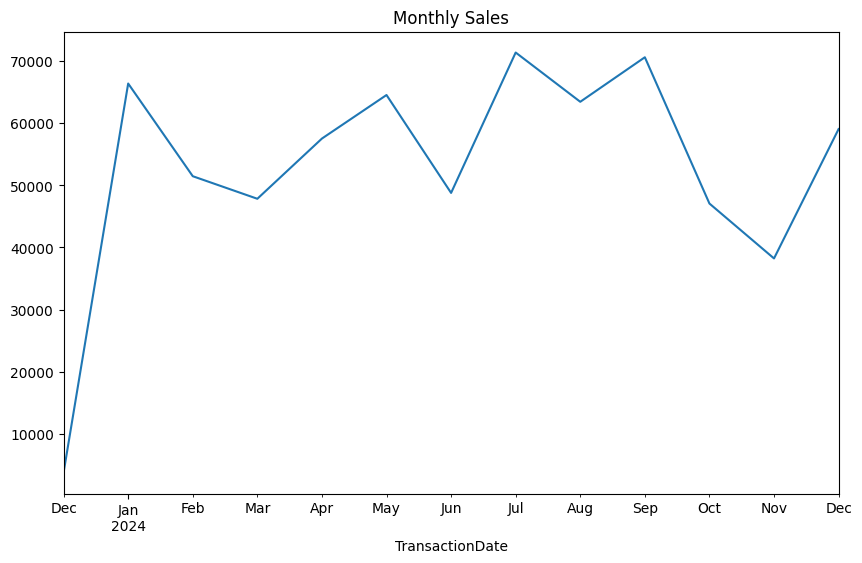

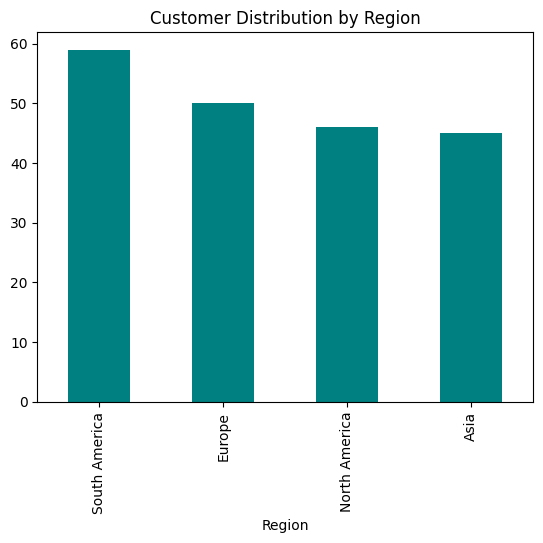

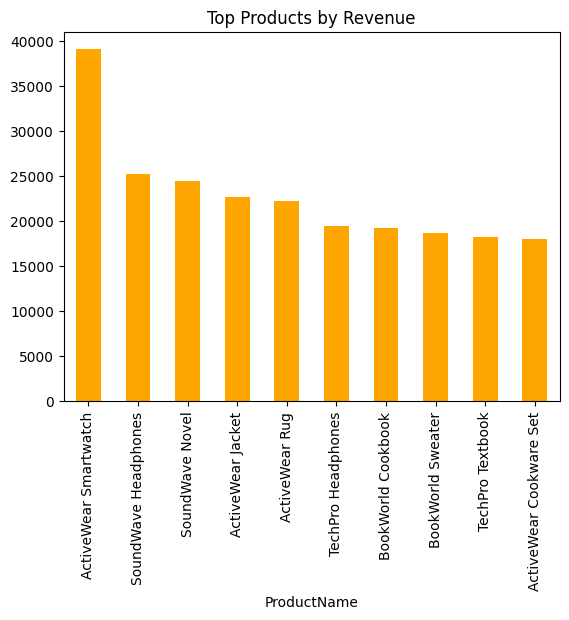

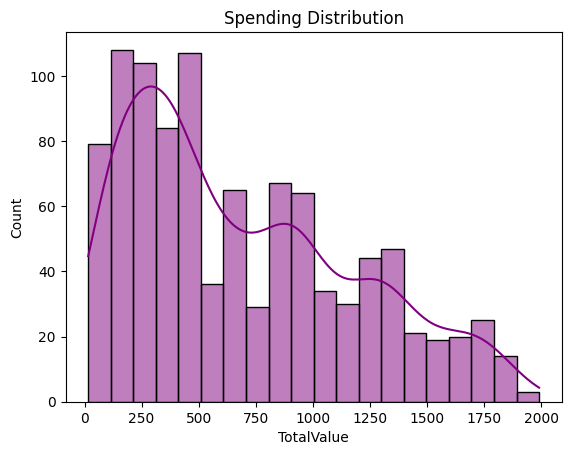

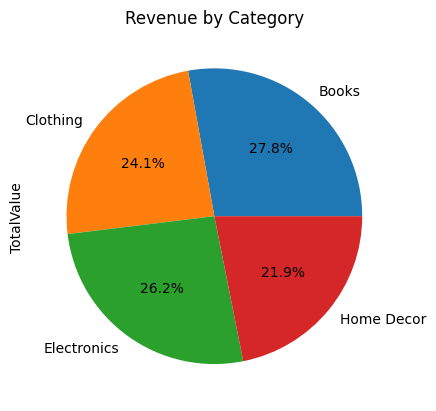

In [4]:
!pip install pandas numpy matplotlib seaborn gdown

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gdown

# Download the datasets using gdown
# Get the file ID from the Google Drive sharing link (between '/d/' and '/view')
customers_id = '1bu_--mo79VdUG9oin4ybfFGRUSXAe-WE'
products_id = '1IKuDizVapw-hyktwfpoAoaGtHtTNHfd0'
transactions_id = '1saEqdbBB-vuk2hxoAf4TzDEsykdKlzbF'

# Download the files
gdown.download(f'https://drive.google.com/uc?id={customers_id}', 'Customers.csv', quiet=False)
gdown.download(f'https://drive.google.com/uc?id={products_id}', 'Products.csv', quiet=False)
gdown.download(f'https://drive.google.com/uc?id={transactions_id}', 'Transactions.csv', quiet=False)

# Load datasets
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

# Convert dates to datetime
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

# Merge datasets for analysis
data = pd.merge(transactions, customers, on='CustomerID')
data = pd.merge(data, products, on='ProductID')

# Summary Statistics
print(data.info())
print(data.describe())

# Visualizations
# 1. Sales over time
# Selecting 'TotalValue' before sum to avoid summing datetime column
sales_over_time = data.groupby(data['TransactionDate'].dt.to_period('M'))['TotalValue'].sum()
sales_over_time.plot(kind='line', figsize=(10, 6), title='Monthly Sales')
plt.show()

# 2. Customer distribution by region
region_distribution = customers['Region'].value_counts()
region_distribution.plot(kind='bar', title='Customer Distribution by Region', color='teal')
plt.show()

# 3. Top products by revenue
top_products = data.groupby('ProductName')['TotalValue'].sum().nlargest(10)
top_products.plot(kind='bar', title='Top Products by Revenue', color='orange')
plt.show()

# 4. Spending distribution
sns.histplot(data['TotalValue'], bins=20, kde=True, color='purple')
plt.title('Spending Distribution')
plt.show()

# 5. Category-wise revenue
category_revenue = data.groupby('Category')['TotalValue'].sum()
category_revenue.plot(kind='pie', autopct='%1.1f%%', title='Revenue by Category')
plt.show()

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

# Data preparation
customer_data = data.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'ProductID': 'nunique'
}).reset_index()
customer_data.columns = ['CustomerID', 'TotalSpending', 'TotalQuantity', 'UniqueProducts']

# Standardize data
scaler = StandardScaler()
features = scaler.fit_transform(customer_data[['TotalSpending', 'TotalQuantity', 'UniqueProducts']])

# Compute similarity
similarity_matrix = cosine_similarity(features)

# Find top 3 similar customers
lookalikes = {}
for i in range(len(customer_data)):
    customer_id = customer_data.loc[i, 'CustomerID']
    scores = list(enumerate(similarity_matrix[i]))
    scores = sorted(scores, key=lambda x: x[1], reverse=True)[1:4]
    lookalikes[customer_id] = [(customer_data.loc[j, 'CustomerID'], round(score, 4)) for j, score in scores]

# Save lookalikes to CSV
lookalike_results = []
for customer_id, similar_customers in lookalikes.items():
    lookalike_results.append({
        'CustomerID': customer_id,
        'SimilarCustomers': str(similar_customers)
    })

lookalike_df = pd.DataFrame(lookalike_results)
lookalike_df.to_csv('Lookalike.csv', index=False)


Davies-Bouldin Index: 0.8956923630972515


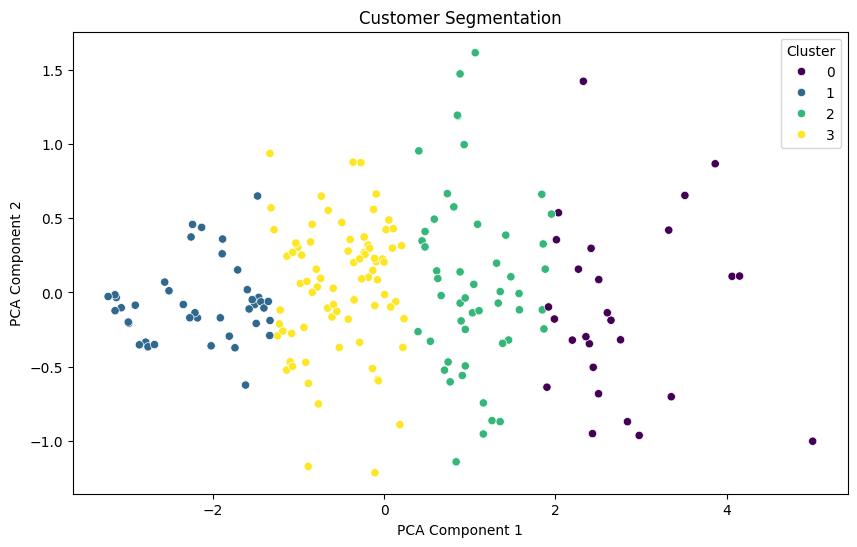

In [3]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt

# Use customer data for clustering
X = features

# KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(X)
customer_data['Cluster'] = labels

# Evaluate clusters
db_index = davies_bouldin_score(X, labels)
print(f'Davies-Bouldin Index: {db_index}')

# Visualize clusters using PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(X)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=labels, palette='viridis')
plt.title('Customer Segmentation')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

# Save clustering results
customer_data.to_csv('Customer_Clustering.csv', index=False)
